**Solving tasks using one Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

# Data Loading

In [2]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [3]:
train_tasks = load_data('../input/abstraction-and-reasoning-challenge/training/')
evaluation_tasks = load_data('../input/abstraction-and-reasoning-challenge/evaluation/')
test_tasks = load_data('../input/abstraction-and-reasoning-challenge/test/')

train_tasks.head()

99fa7670    {'train': [{'input': [[0, 0, 0, 0, 0, 0], [0, ...
8731374e    {'train': [{'input': [[6, 1, 2, 4, 8, 3, 7, 2,...
4522001f    {'train': [{'input': [[3, 3, 0], [3, 2, 0], [0...
62c24649    {'train': [{'input': [[3, 3, 3], [0, 2, 2], [1...
0962bcdd    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

# Model

In [4]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn import Conv2d
from torch import FloatTensor, LongTensor



def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


class TaskSolver:        
    def train(self, task_train, n_epoch=30):
        """basic pytorch train loop"""
        self.net = Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)
        
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in range(n_epoch):
            for sample in task_train:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)
                
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        return self
            
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                outputs = self.net(inputs)
                pred =  outputs.squeeze(dim=0).cpu().numpy().argmax(0)
                predictions.append(pred)
                                     
        return predictions

# Results

In [5]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [6]:
def evaluate(tasks):
    ts = TaskSolver()
    result = []
    predictions = []
    for task in tqdm(tasks):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
            score = calk_score(task['test'], pred)
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        result.append(score)
       
    return result, predictions

In [7]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [00:38<00:00, 10.53it/s]

solved : 12 from 416 (0.028846153846153848)


In [8]:
evaluation_result, evaluation_predictions = evaluate(evaluation_tasks)
evaluation_solved = [any(score) for score in evaluation_result]

total = sum([len(score) for score in evaluation_result])
print(f"solved : {sum(evaluation_solved)} from {total} ({sum(evaluation_solved)/total})")

100%|██████████| 400/400 [00:45<00:00,  8.83it/s]

solved : 4 from 419 (0.00954653937947494)


# Visualize

visualize solved tasks

In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors


cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

### train solved tasks

0it [00:00, ?it/s]

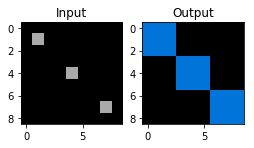

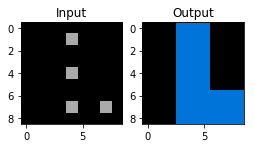

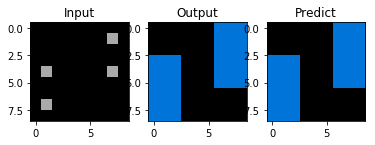

38it [00:01, 34.28it/s]

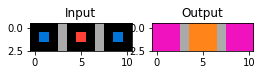

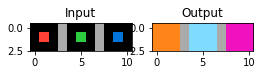

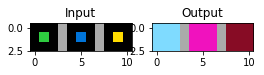

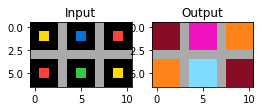

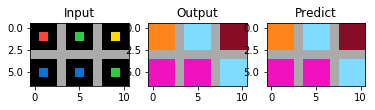

67it [00:02, 26.09it/s]

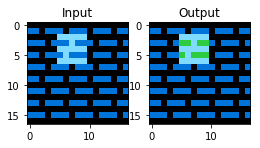

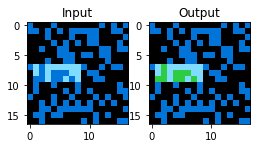

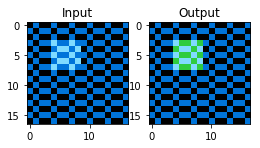

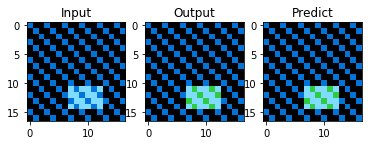

92it [00:04, 23.54it/s]

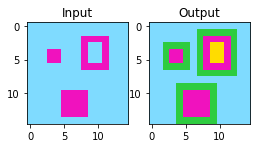

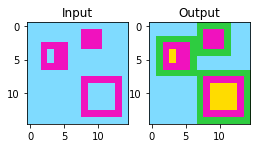

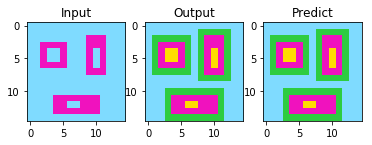

109it [00:05, 20.97it/s]

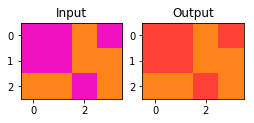

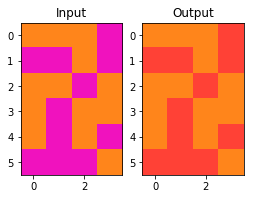

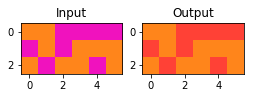

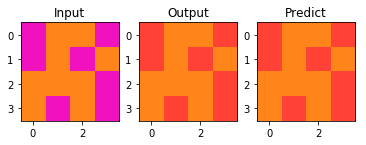

122it [00:06, 15.60it/s]

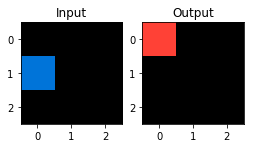

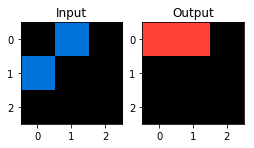

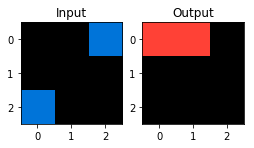

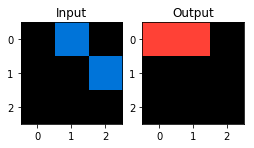

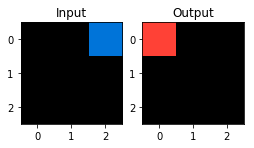

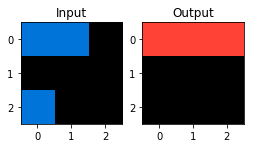

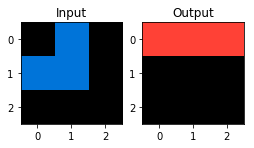

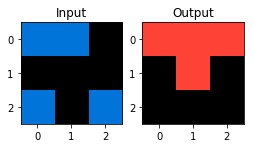

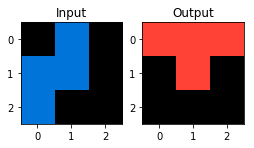

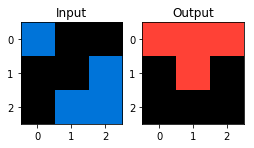

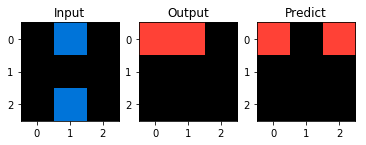

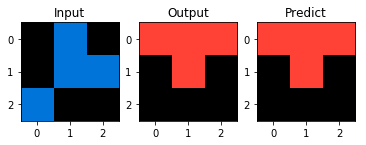

124it [00:10,  1.47it/s]

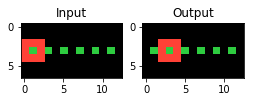

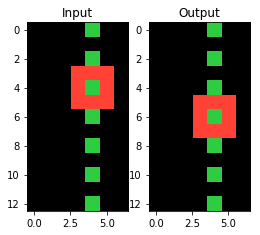

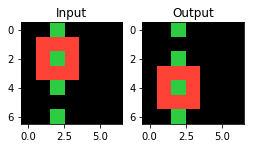

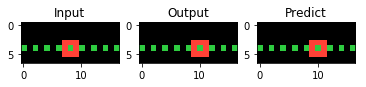

174it [00:12,  2.05it/s]

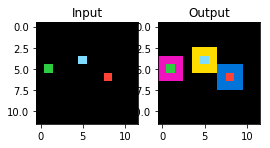

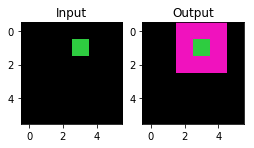

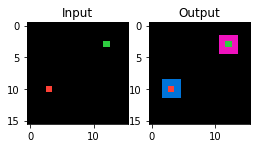

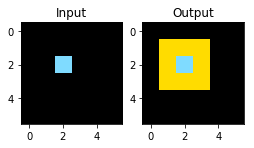

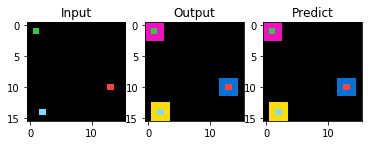

233it [00:14,  2.83it/s]

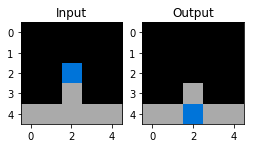

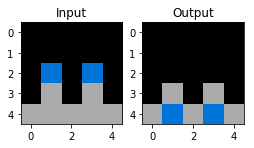

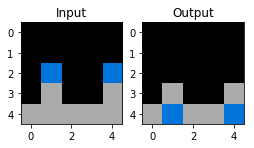

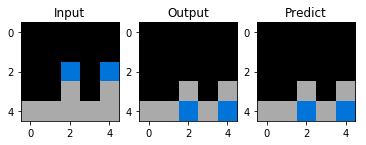

242it [00:16,  3.26it/s]

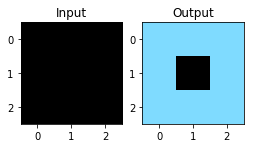

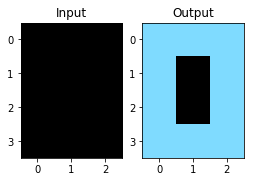

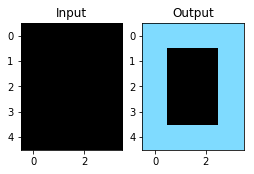

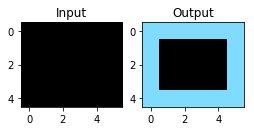

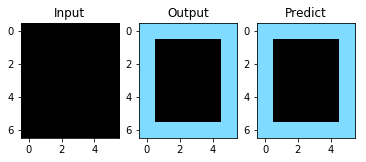

302it [00:19,  4.42it/s]

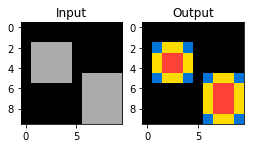

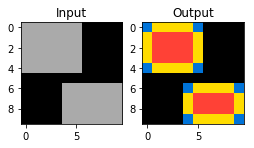

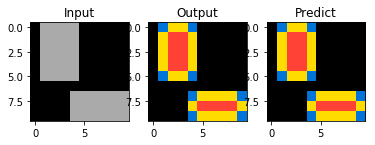

314it [00:20,  5.14it/s]

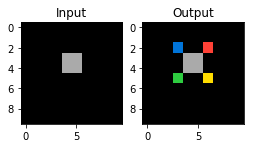

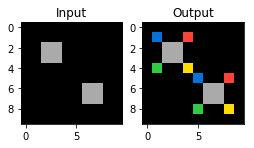

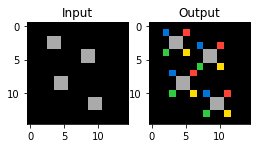

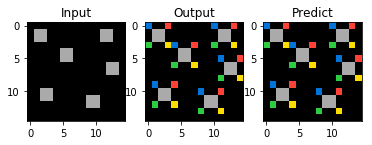

400it [00:21, 18.33it/s]


In [10]:
for task, prediction, solved in tqdm(zip(train_tasks, train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

### evaluation solved tasks

0it [00:00, ?it/s]

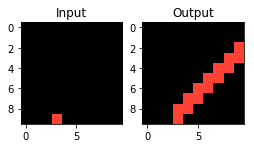

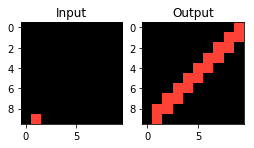

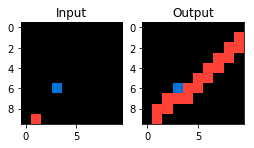

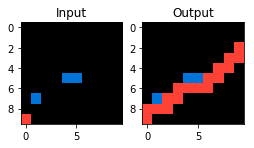

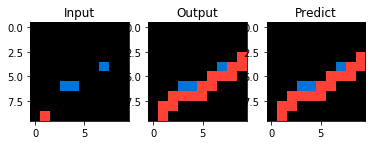

52it [00:01, 31.39it/s]

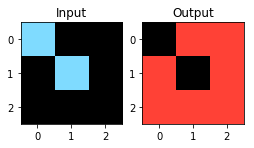

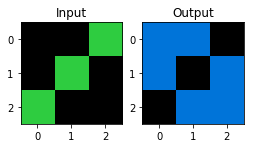

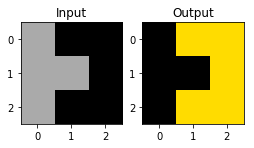

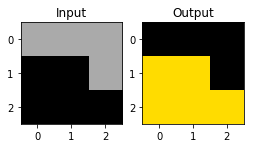

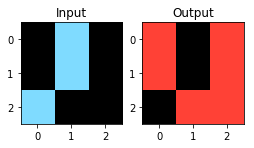

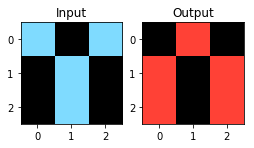

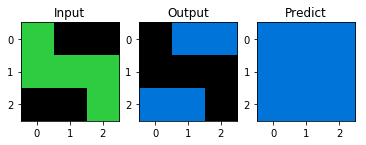

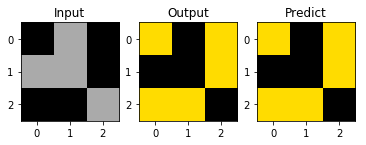

124it [00:04, 29.25it/s]

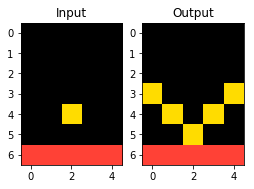

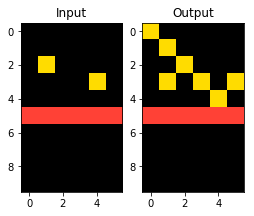

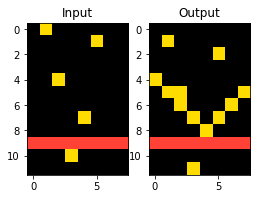

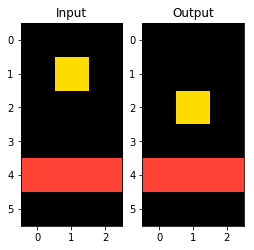

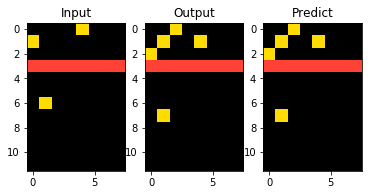

214it [00:06, 33.29it/s]

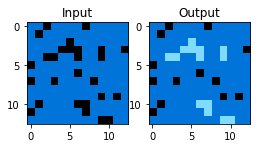

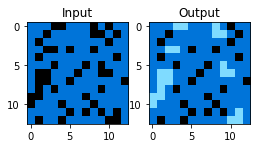

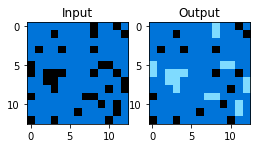

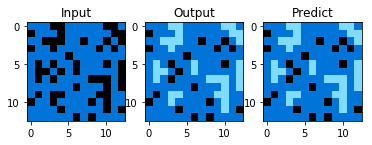

400it [00:07, 50.26it/s]


In [11]:
for task, prediction, solved in tqdm(zip(evaluation_tasks, evaluation_predictions, evaluation_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

# Prediction

In [12]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def make_pediction(tasks):
    ts = TaskSolver()
    result = pd.Series()
    for idx, task in tqdm(test_tasks.iteritems()):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
        else:
            pred = [el['input'] for el in task['test']]
        
        for i, p in enumerate(pred):
            result[f'{idx}_{i}'] = flattener(np.array(p).tolist())
       
    return result

In [13]:
submission = make_pediction(test_tasks)
submission.head()

100it [00:11,  8.70it/s]


22a4bbc2_0    |8220|0212|0820|2111|2820|8820|0111|0810|0820|...
15663ba9_0    |0000000000000000|0043400434000000|04203334030...
32e9702f_0    |5557555555|5555555555|5555555555|5555555555|5...
3ed85e70_0    |000000000000000000000000000000|08881000000000...
414297c0_0    |000000000000000000000000|00000000000000000000...
dtype: object

In [14]:
submission = submission.reset_index()
submission.columns = ['output_id', 'output']
submission.to_csv('submission.csv', index=False)
submission

,output_id,output
0,22a4bbc2_0,|8220|0212|0820|2111|2820|8820|0111|0810|0820|...
1,15663ba9_0,|0000000000000000|0043400434000000|04203334030...
2,32e9702f_0,|5557555555|5555555555|5555555555|5555555555|5...
3,3ed85e70_0,|000000000000000000000000000000|08881000000000...
4,414297c0_0,|000000000000000000000000|00000000000000000000...
...,...,...
99,20818e16_0,|1111111111111111|1122222222221111|11222222222...
100,009d5c81_0,|00000000000000|00000227222772|00000300020207|...
101,351d6448_0,|0020002000200|0322022202220|3322222222222|555...
102,310f3251_0,|0040|0000|0000|4000|


# All train tasks predictions

0it [00:00, ?it/s]

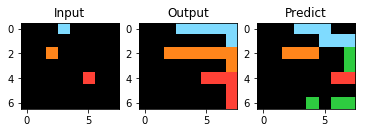

1it [00:00,  1.81it/s]

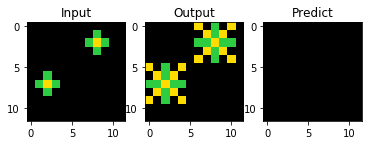

5it [00:01,  2.38it/s]

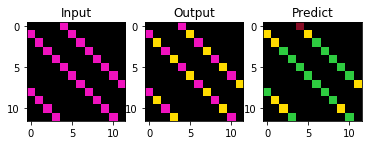

7it [00:01,  2.77it/s]

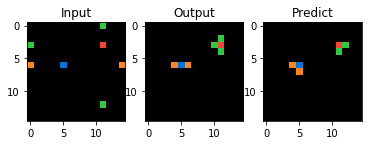

8it [00:01,  2.58it/s]

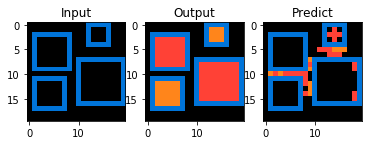

9it [00:02,  2.46it/s]

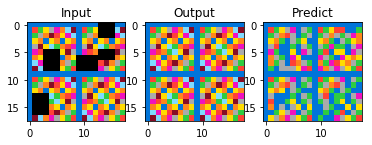

13it [00:02,  3.05it/s]

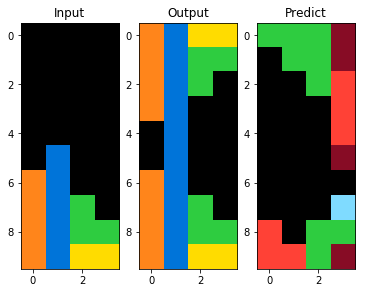

15it [00:03,  3.34it/s]

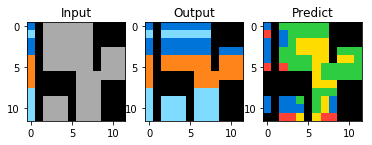

16it [00:03,  2.87it/s]

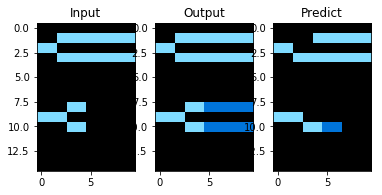

18it [00:04,  2.96it/s]

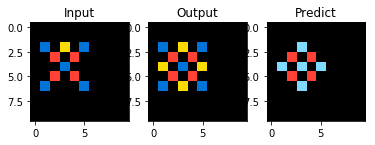

19it [00:05,  2.43it/s]

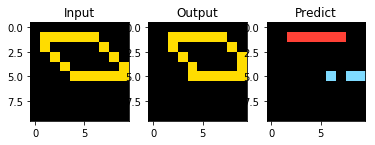

20it [00:05,  2.17it/s]

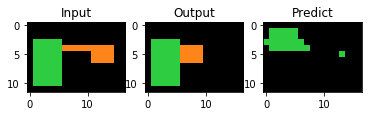

22it [00:06,  2.45it/s]

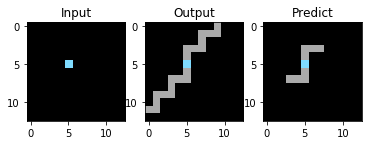

23it [00:06,  2.17it/s]

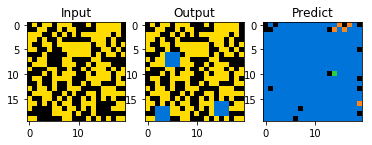

24it [00:07,  1.99it/s]

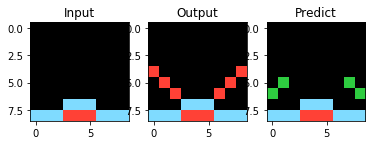

25it [00:08,  1.87it/s]

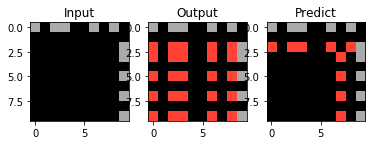

26it [00:08,  1.82it/s]

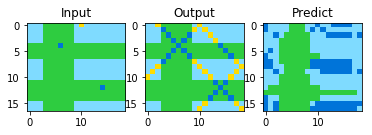

27it [00:09,  1.65it/s]

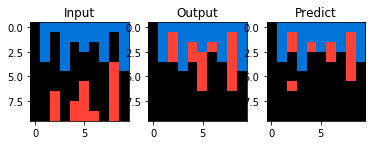

28it [00:09,  1.67it/s]

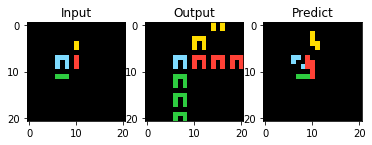

31it [00:10,  2.08it/s]

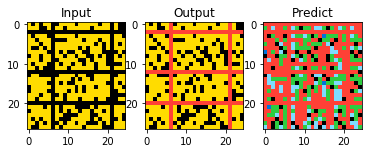

33it [00:11,  2.34it/s]

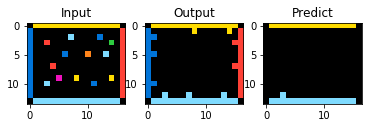

34it [00:11,  2.12it/s]

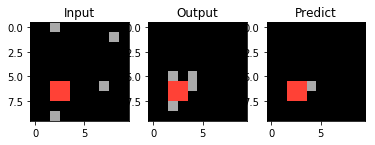

35it [00:12,  1.98it/s]

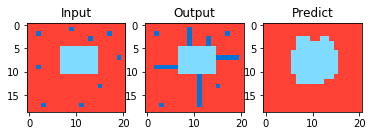

36it [00:12,  1.88it/s]

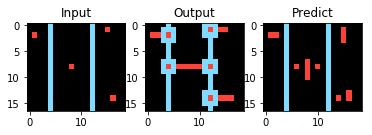

37it [00:13,  1.84it/s]

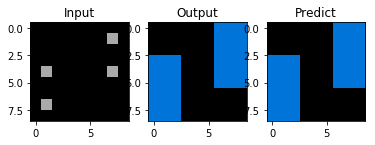

38it [00:14,  1.80it/s]

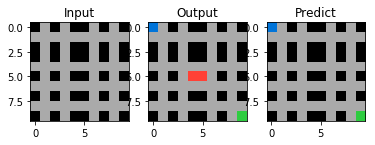

39it [00:14,  1.80it/s]

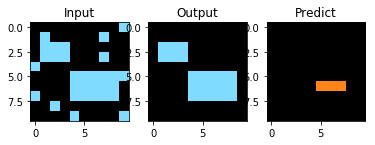

41it [00:15,  2.11it/s]

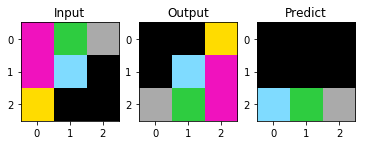

46it [00:15,  2.65it/s]

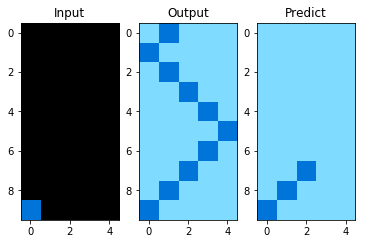

47it [00:16,  2.23it/s]

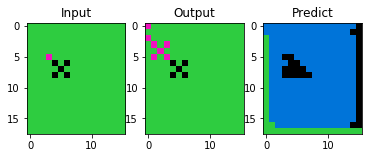

49it [00:17,  2.49it/s]

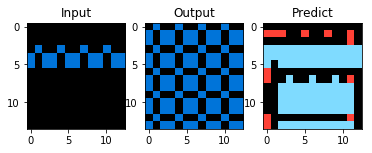

50it [00:17,  2.19it/s]

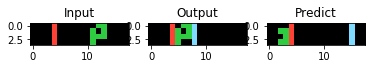

51it [00:18,  2.13it/s]

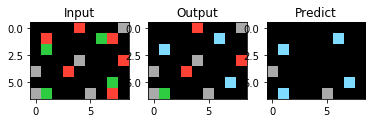

53it [00:18,  2.54it/s]

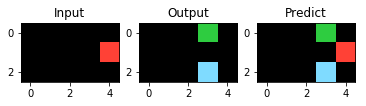

54it [00:19,  2.46it/s]

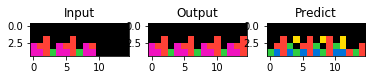

55it [00:19,  2.42it/s]

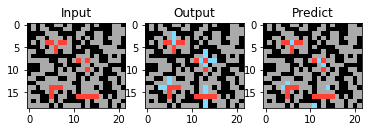

56it [00:19,  2.35it/s]

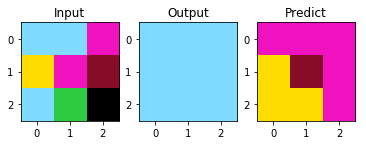

60it [00:20,  3.03it/s]

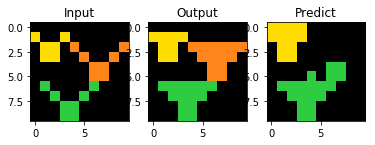

61it [00:20,  2.78it/s]

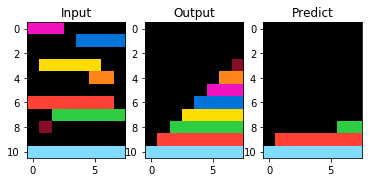

62it [00:21,  2.59it/s]

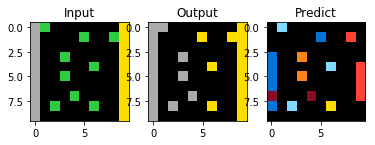

63it [00:21,  2.27it/s]

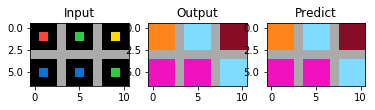

67it [00:22,  2.94it/s]

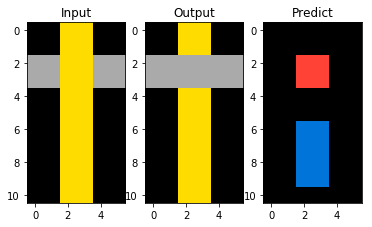

68it [00:22,  2.67it/s]

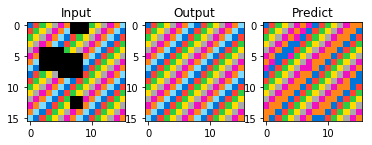

69it [00:23,  2.56it/s]

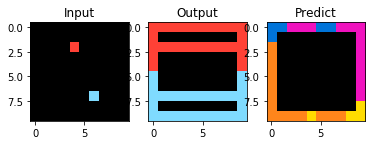

70it [00:23,  2.48it/s]

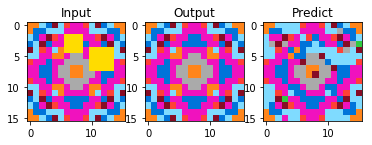

71it [00:24,  2.40it/s]

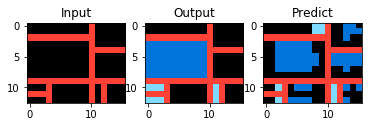

72it [00:24,  2.38it/s]

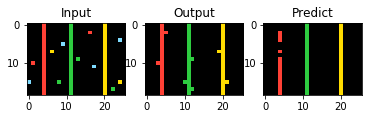

73it [00:24,  2.36it/s]

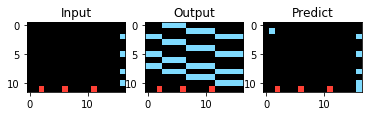

74it [00:25,  2.34it/s]

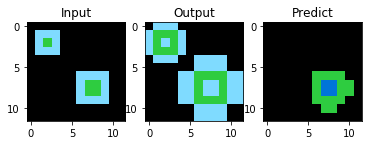

76it [00:25,  2.73it/s]

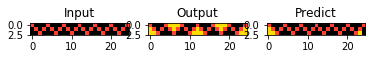

78it [00:26,  3.12it/s]

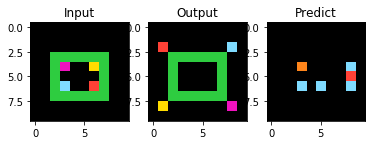

79it [00:26,  2.48it/s]

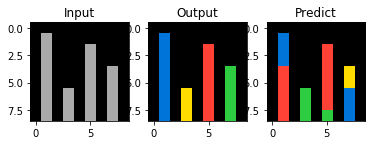

80it [00:27,  2.39it/s]

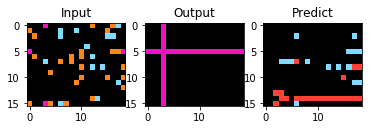

81it [00:27,  2.35it/s]

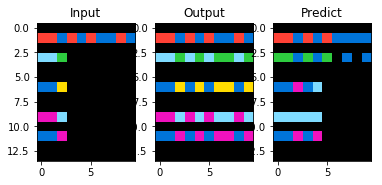

82it [00:28,  2.17it/s]

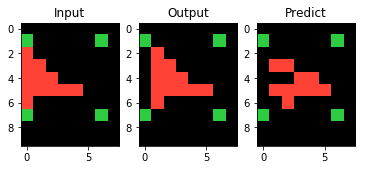

83it [00:28,  2.01it/s]

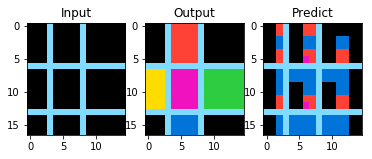

84it [00:29,  1.89it/s]

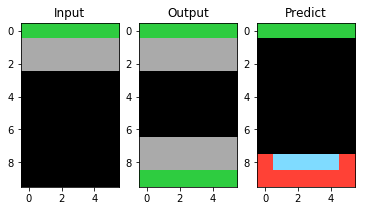

85it [00:30,  1.81it/s]

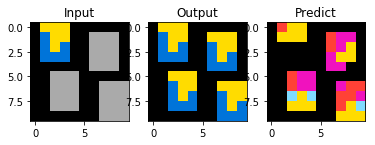

86it [00:30,  1.79it/s]

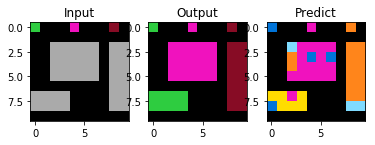

87it [00:31,  1.78it/s]

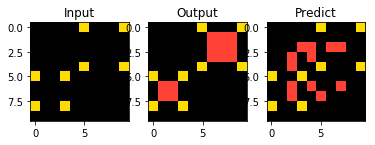

88it [00:31,  1.77it/s]

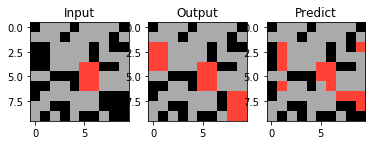

89it [00:32,  1.78it/s]

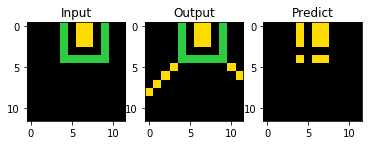

90it [00:32,  1.78it/s]

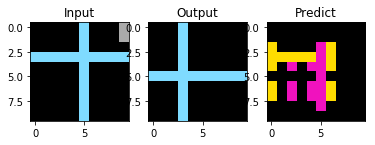

91it [00:33,  1.65it/s]

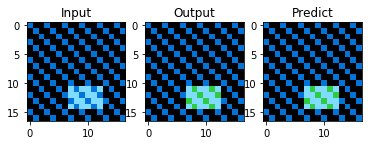

92it [00:34,  1.68it/s]

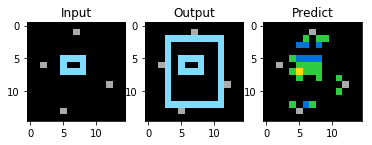

94it [00:34,  1.99it/s]

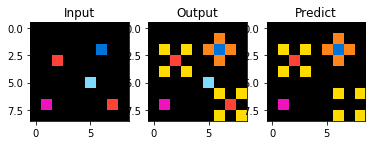

95it [00:35,  1.90it/s]

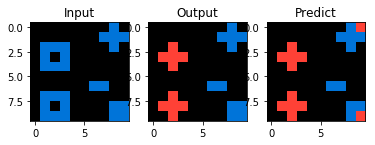

99it [00:35,  2.43it/s]

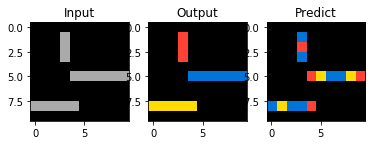

101it [00:36,  2.66it/s]

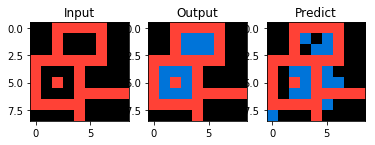

103it [00:37,  2.84it/s]

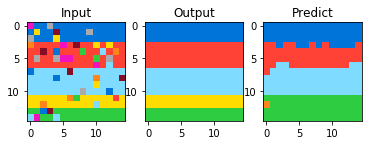

104it [00:37,  2.37it/s]

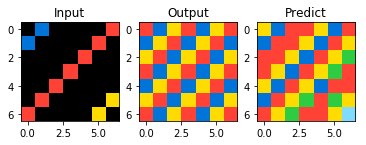

105it [00:38,  2.13it/s]

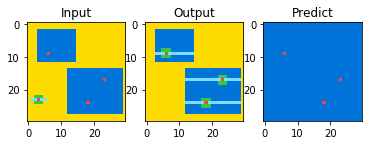

106it [00:38,  2.17it/s]

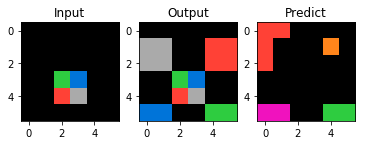

107it [00:39,  2.18it/s]

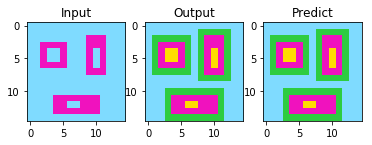

109it [00:39,  2.42it/s]

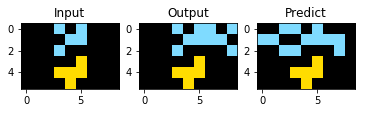

110it [00:40,  2.38it/s]

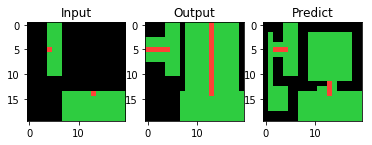

113it [00:40,  2.95it/s]

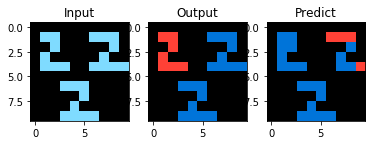

114it [00:41,  2.71it/s]

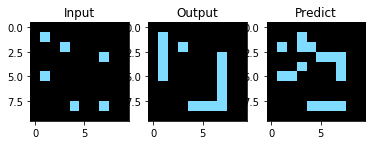

115it [00:41,  2.54it/s]

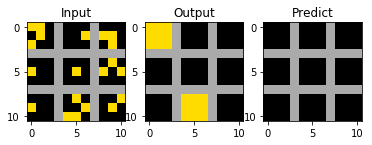

118it [00:41,  3.12it/s]

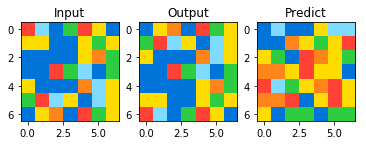

119it [00:42,  2.76it/s]

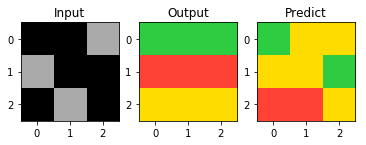

120it [00:42,  2.59it/s]

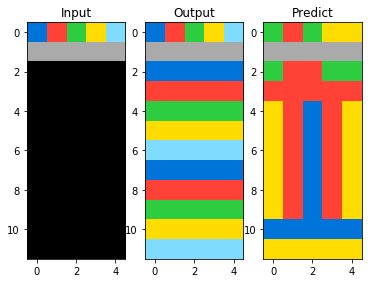

121it [00:43,  2.40it/s]

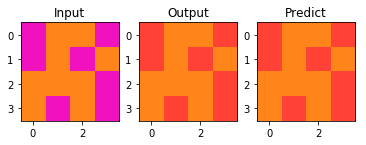

122it [00:43,  2.36it/s]

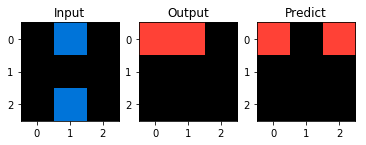

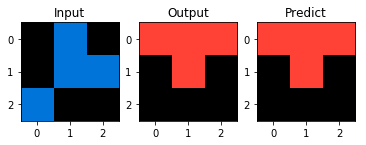

124it [00:44,  2.33it/s]

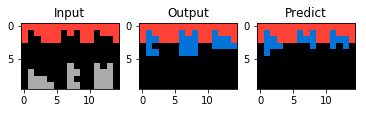

125it [00:45,  2.14it/s]

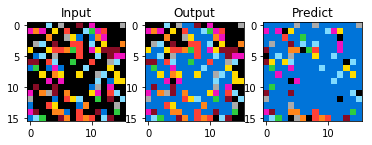

126it [00:45,  2.18it/s]

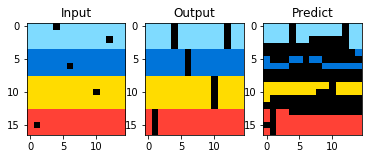

128it [00:46,  2.56it/s]

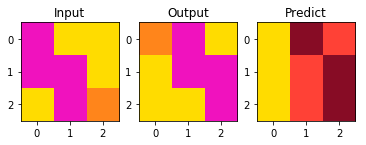

129it [00:46,  2.46it/s]

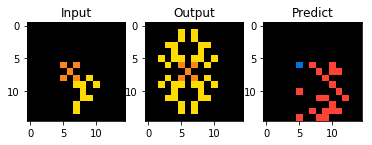

133it [00:47,  3.14it/s]

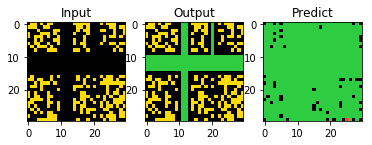

134it [00:47,  2.79it/s]

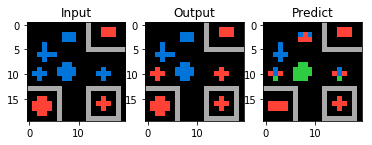

135it [00:47,  2.56it/s]

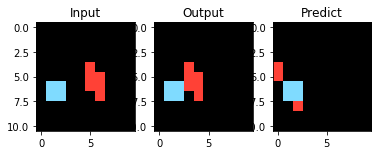

136it [00:48,  2.15it/s]

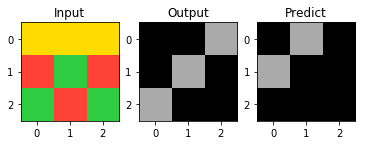

137it [00:49,  1.99it/s]

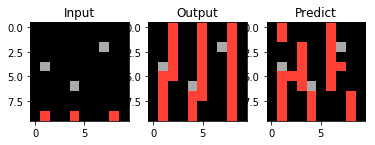

138it [00:49,  1.91it/s]

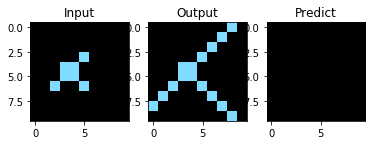

139it [00:50,  1.86it/s]

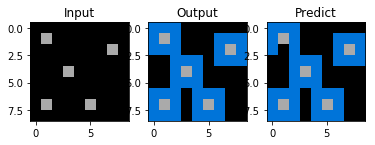

146it [00:51,  2.45it/s]

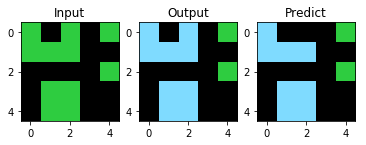

148it [00:51,  2.70it/s]

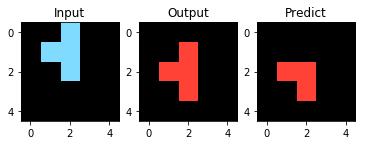

149it [00:52,  2.36it/s]

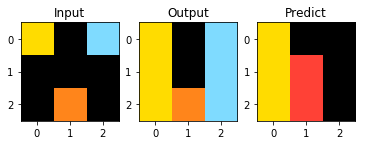

151it [00:52,  2.74it/s]

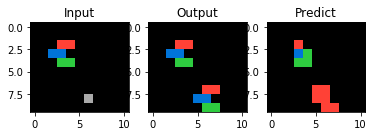

152it [00:53,  2.55it/s]

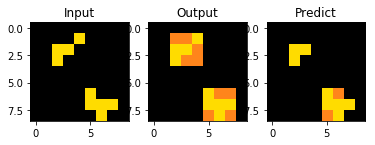

154it [00:53,  2.89it/s]

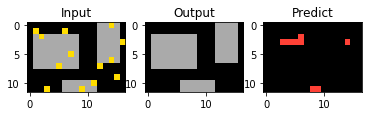

156it [00:53,  3.26it/s]

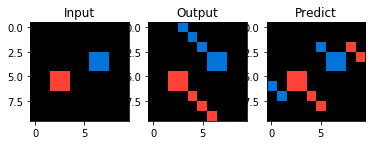

158it [00:54,  3.54it/s]

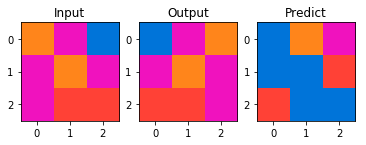

159it [00:54,  3.07it/s]

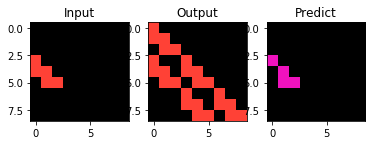

160it [00:55,  2.59it/s]

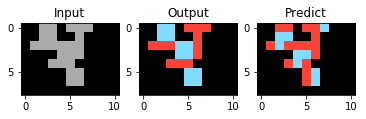

161it [00:55,  2.47it/s]

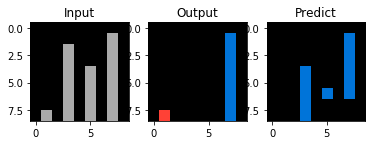

163it [00:56,  2.54it/s]

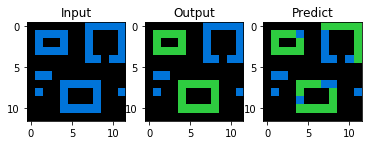

164it [00:57,  2.18it/s]

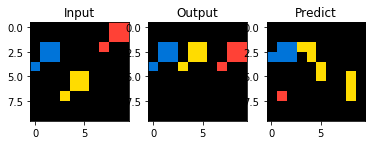

165it [00:57,  2.02it/s]

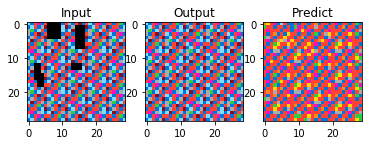

166it [00:58,  1.92it/s]

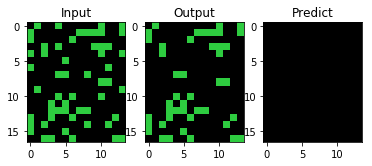

168it [00:58,  2.25it/s]

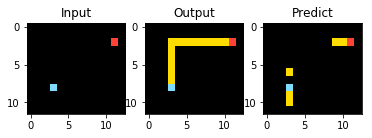

169it [00:59,  2.26it/s]

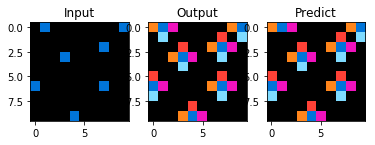

170it [00:59,  2.27it/s]

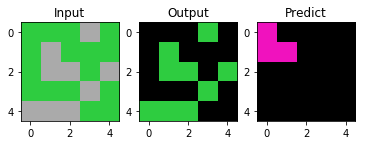

172it [01:00,  2.66it/s]

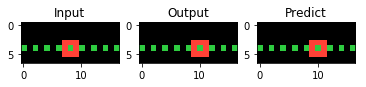

174it [01:00,  3.06it/s]

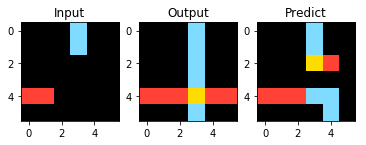

175it [01:01,  2.75it/s]

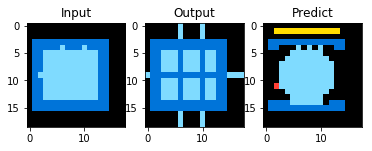

176it [01:01,  2.55it/s]

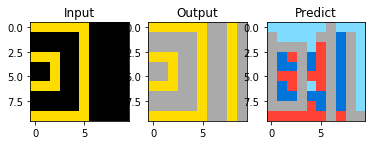

177it [01:01,  2.47it/s]

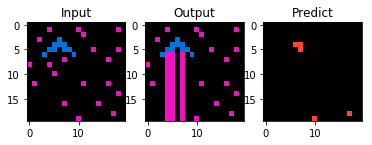

178it [01:02,  1.99it/s]

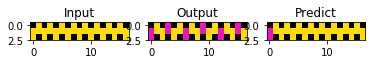

179it [01:03,  1.94it/s]

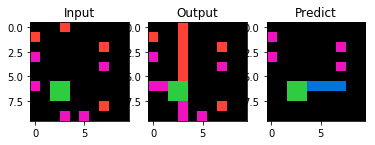

183it [01:03,  2.48it/s]

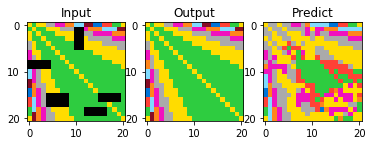

184it [01:04,  2.16it/s]

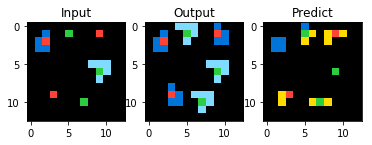

186it [01:04,  2.42it/s]

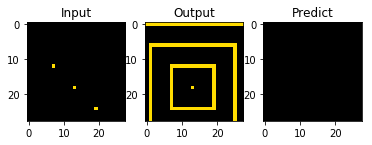

187it [01:05,  2.14it/s]

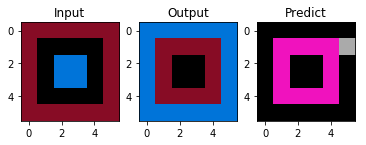

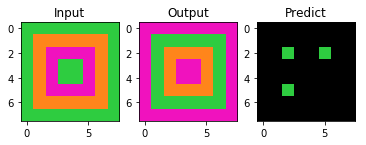

188it [01:06,  1.47it/s]

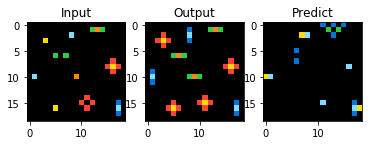

191it [01:07,  1.87it/s]

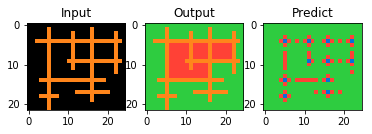

192it [01:07,  1.81it/s]

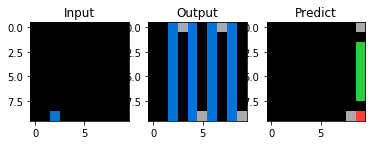

193it [01:08,  1.78it/s]

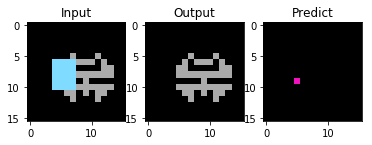

194it [01:09,  1.62it/s]

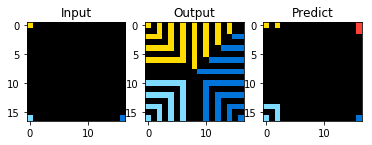

195it [01:09,  1.65it/s]

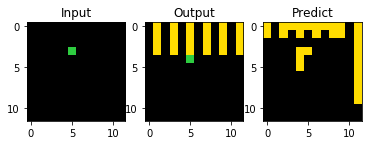

196it [01:10,  1.65it/s]

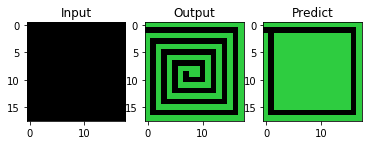

199it [01:11,  2.06it/s]

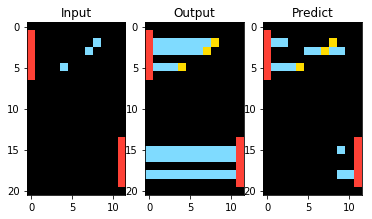

200it [01:11,  1.89it/s]

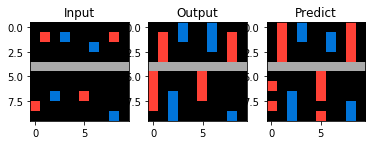

201it [01:12,  1.83it/s]

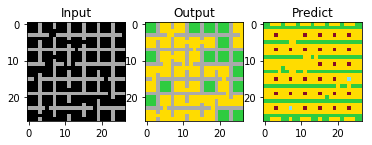

202it [01:12,  1.80it/s]

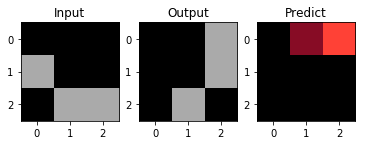

203it [01:13,  1.78it/s]

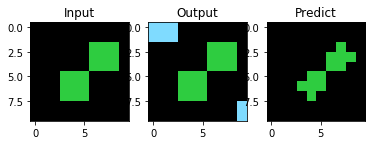

204it [01:14,  1.78it/s]

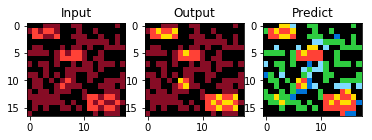

205it [01:14,  1.77it/s]

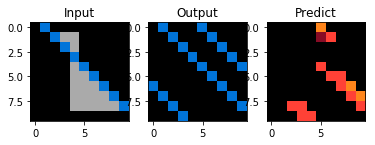

206it [01:15,  1.77it/s]

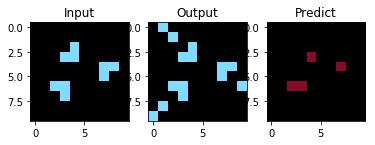

207it [01:15,  1.63it/s]

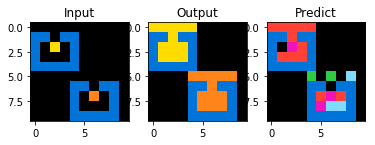

212it [01:16,  2.15it/s]

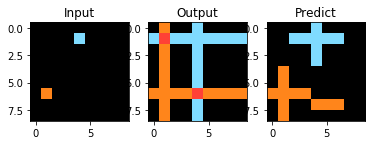

214it [01:17,  2.42it/s]

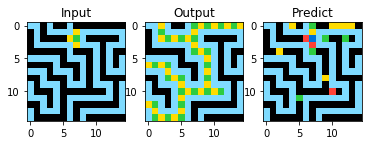

215it [01:17,  2.16it/s]

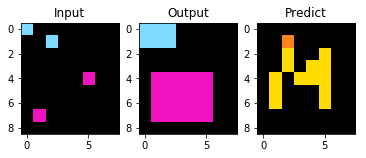

216it [01:18,  1.98it/s]

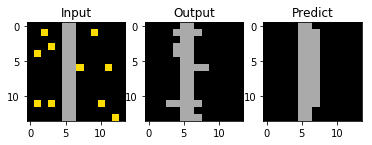

217it [01:18,  1.89it/s]

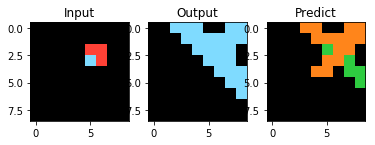

219it [01:19,  2.18it/s]

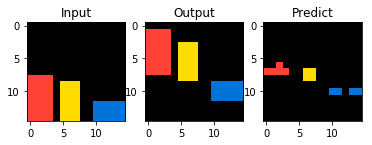

220it [01:19,  2.02it/s]

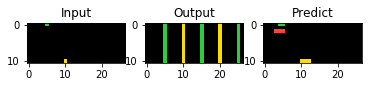

223it [01:20,  2.49it/s]

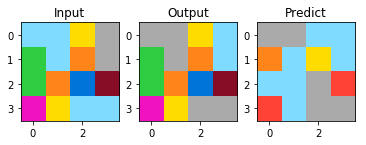

224it [01:21,  2.22it/s]

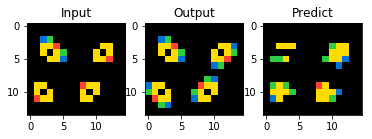

225it [01:21,  2.07it/s]

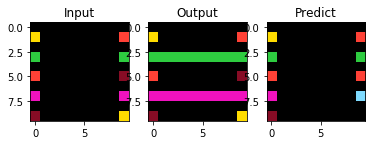

226it [01:22,  1.81it/s]

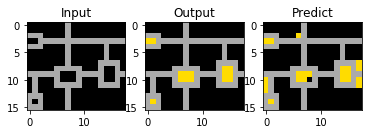

227it [01:22,  1.81it/s]

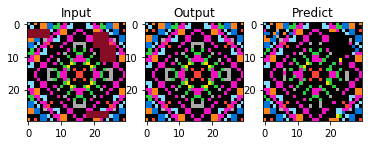

228it [01:23,  1.78it/s]

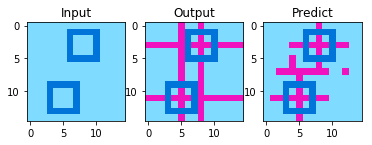

230it [01:24,  2.08it/s]

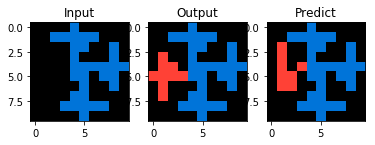

231it [01:24,  1.97it/s]

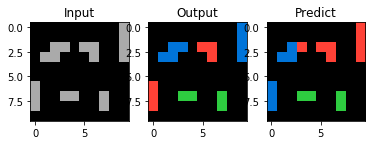

232it [01:25,  1.89it/s]

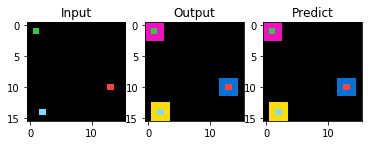

233it [01:25,  1.84it/s]

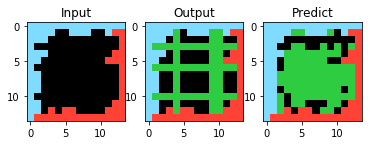

236it [01:26,  2.28it/s]

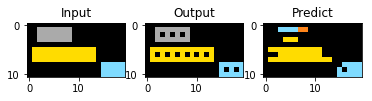

239it [01:26,  2.76it/s]

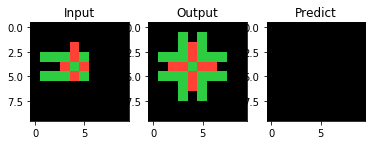

240it [01:27,  2.35it/s]

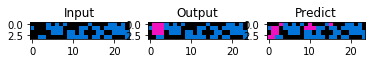

241it [01:28,  2.13it/s]

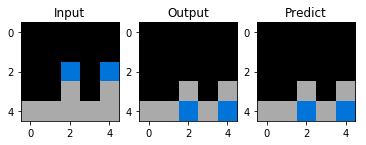

242it [01:28,  1.99it/s]

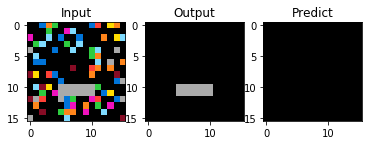

243it [01:29,  1.74it/s]

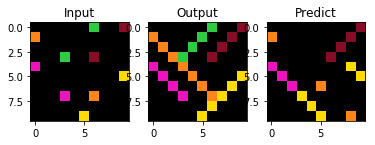

244it [01:29,  1.74it/s]

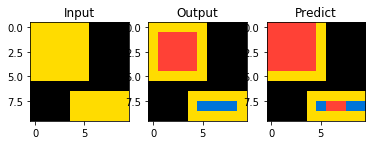

245it [01:30,  1.73it/s]

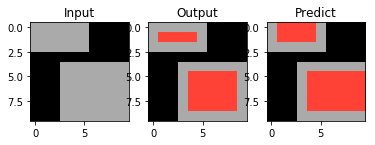

248it [01:31,  2.16it/s]

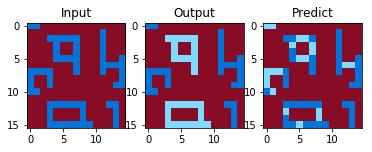

249it [01:31,  1.99it/s]

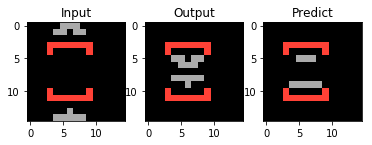

250it [01:32,  1.91it/s]

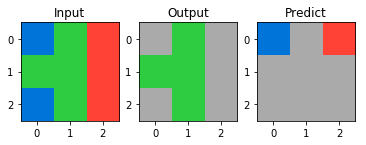

252it [01:32,  2.22it/s]

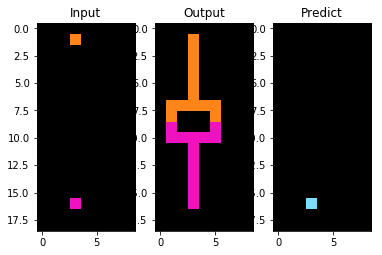

254it [01:33,  2.43it/s]

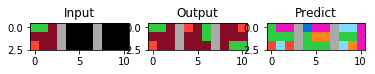

255it [01:34,  2.22it/s]

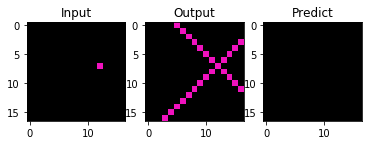

256it [01:34,  2.06it/s]

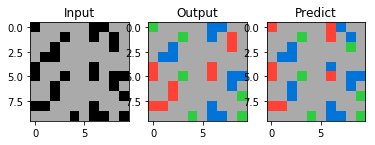

258it [01:35,  2.34it/s]

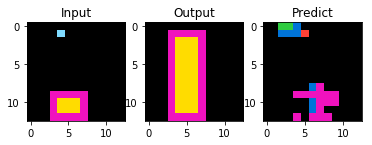

259it [01:35,  1.90it/s]

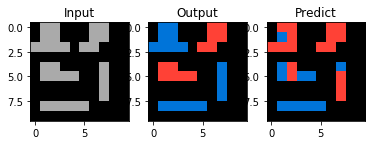

261it [01:36,  2.19it/s]

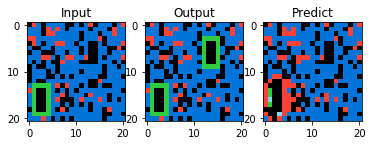

263it [01:37,  2.43it/s]

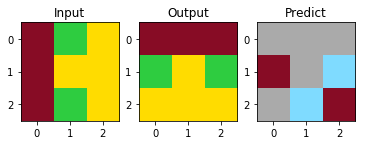

264it [01:37,  2.17it/s]

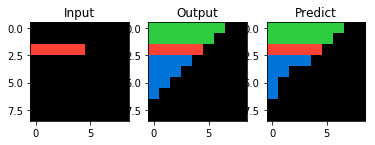

266it [01:38,  2.42it/s]

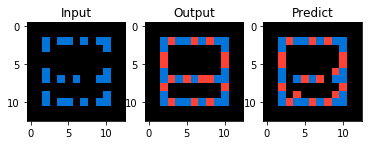

267it [01:38,  2.15it/s]

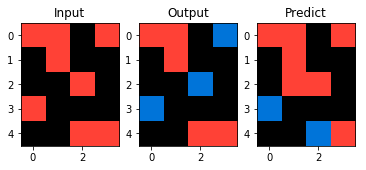

268it [01:39,  1.98it/s]

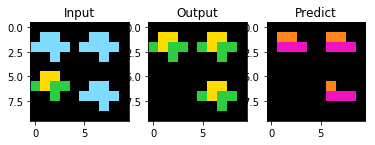

269it [01:40,  1.90it/s]

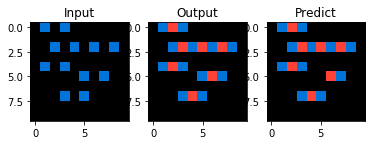

271it [01:40,  2.19it/s]

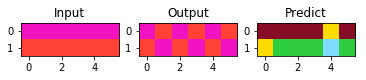

273it [01:41,  2.46it/s]

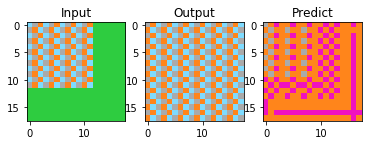

275it [01:41,  2.68it/s]

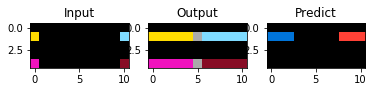

276it [01:42,  2.09it/s]

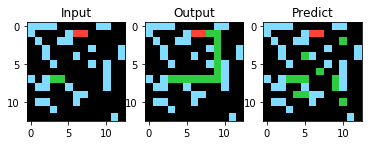

277it [01:43,  1.95it/s]

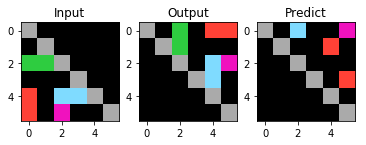

279it [01:43,  2.24it/s]

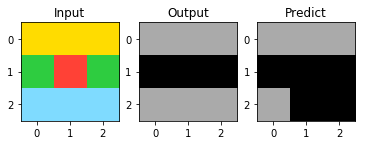

280it [01:44,  2.04it/s]

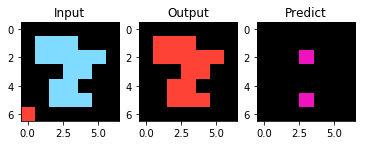

281it [01:44,  1.95it/s]

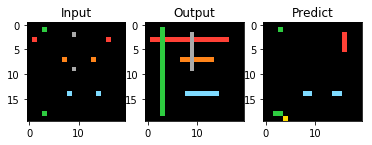

283it [01:45,  2.26it/s]

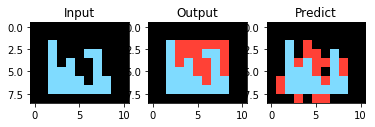

284it [01:46,  2.04it/s]

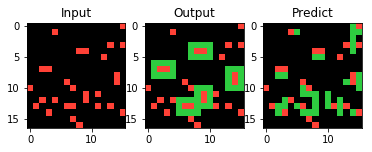

285it [01:46,  1.93it/s]

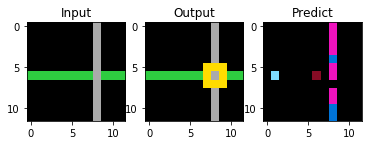

290it [01:47,  2.51it/s]

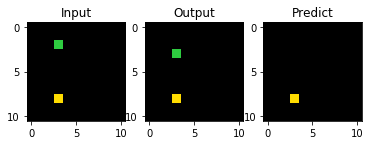

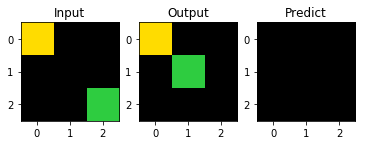

292it [01:48,  2.16it/s]

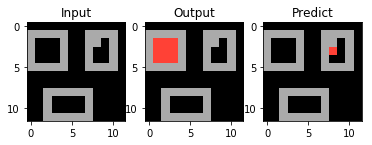

294it [01:49,  2.30it/s]

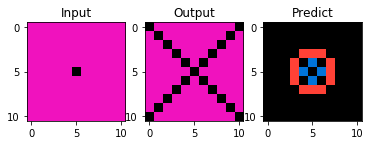

295it [01:49,  2.09it/s]

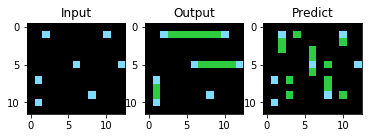

297it [01:50,  2.36it/s]

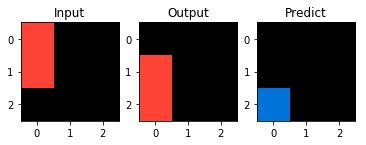

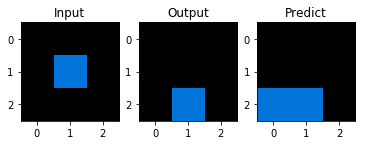

298it [01:51,  1.56it/s]

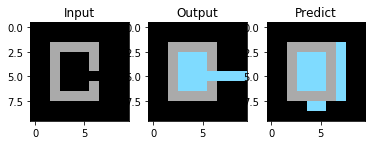

299it [01:52,  1.62it/s]

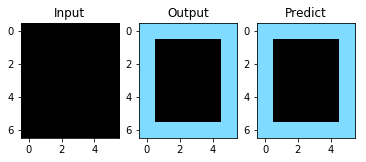

302it [01:52,  2.02it/s]

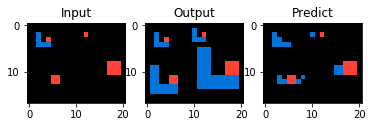

304it [01:53,  2.31it/s]

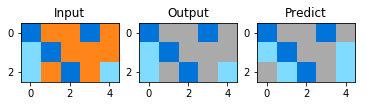

305it [01:53,  2.12it/s]

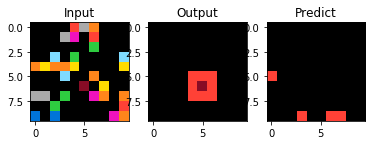

306it [01:54,  2.00it/s]

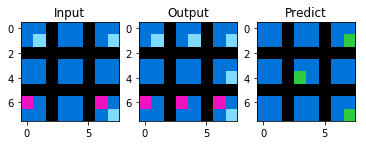

307it [01:54,  1.94it/s]

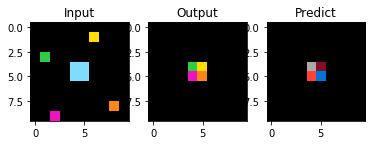

309it [01:55,  2.22it/s]

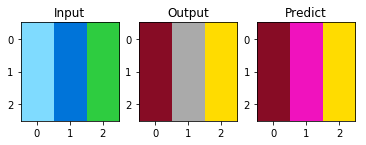

312it [01:56,  2.57it/s]

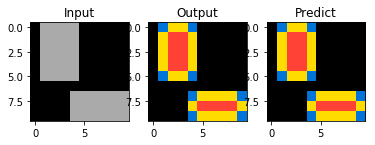

314it [01:56,  2.78it/s]

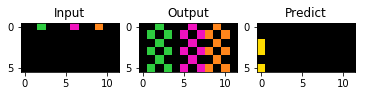

315it [01:57,  2.35it/s]

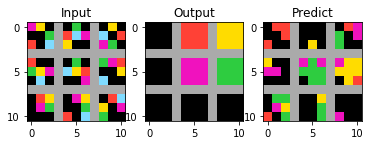

316it [01:58,  2.10it/s]

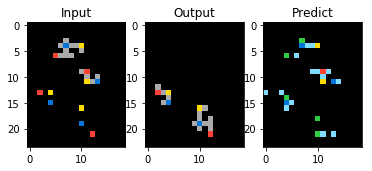

317it [01:58,  2.05it/s]

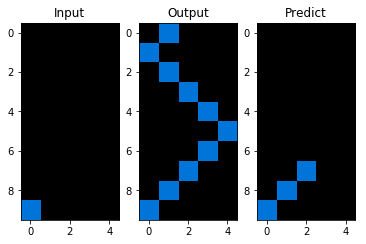

318it [01:59,  2.07it/s]

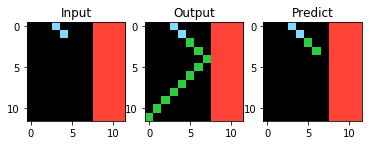

319it [01:59,  2.13it/s]

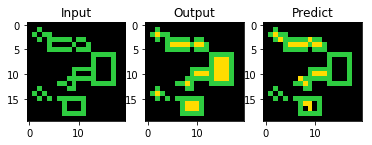

321it [01:59,  2.53it/s]

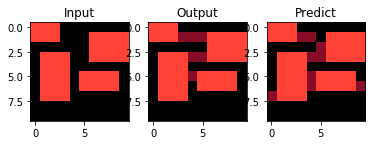

323it [02:00,  2.90it/s]

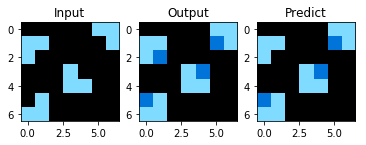

324it [02:00,  2.64it/s]

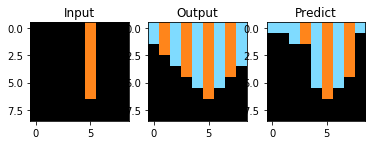

325it [02:01,  2.47it/s]

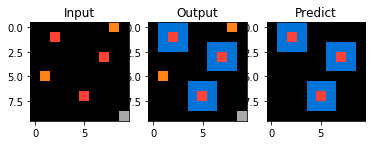

326it [02:01,  2.41it/s]

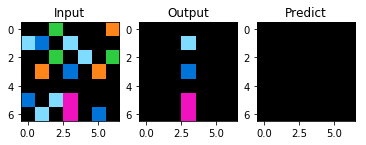

327it [02:02,  2.09it/s]

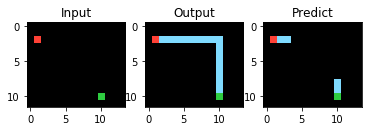

329it [02:02,  2.49it/s]

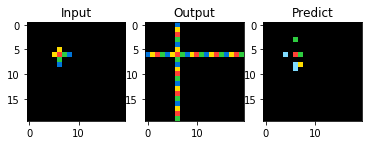

330it [02:03,  2.40it/s]

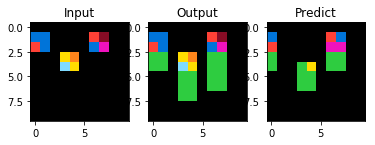

333it [02:03,  2.99it/s]

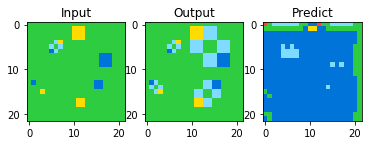

335it [02:04,  3.29it/s]

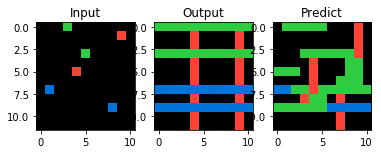

336it [02:04,  2.83it/s]

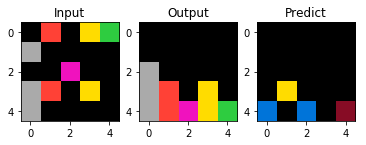

337it [02:05,  2.63it/s]

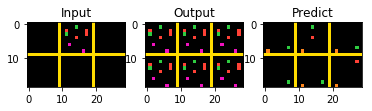

338it [02:05,  2.51it/s]

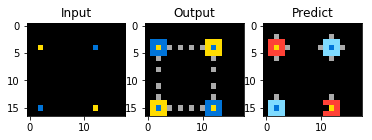

340it [02:06,  2.82it/s]

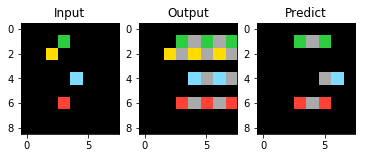

341it [02:06,  2.32it/s]

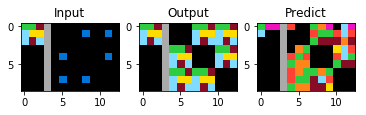

342it [02:07,  2.10it/s]

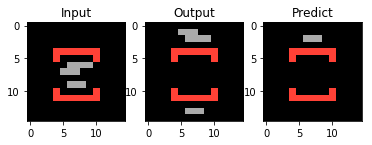

344it [02:07,  2.24it/s]

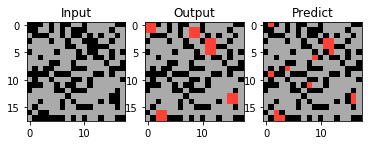

345it [02:08,  2.02it/s]

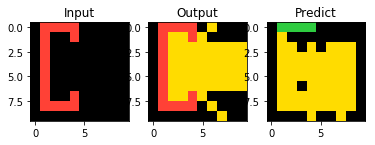

348it [02:09,  2.47it/s]

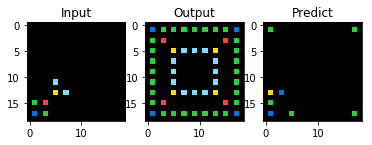

349it [02:09,  2.17it/s]

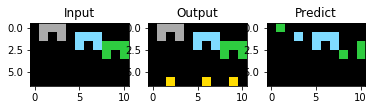

350it [02:10,  2.00it/s]

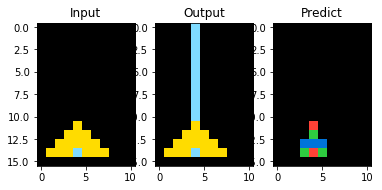

352it [02:10,  2.24it/s]

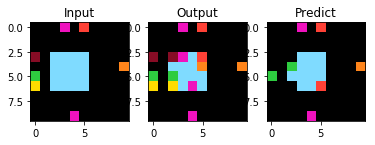

354it [02:11,  2.50it/s]

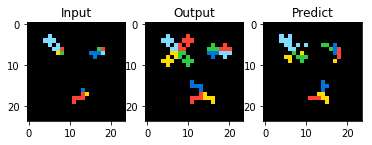

356it [02:12,  2.71it/s]

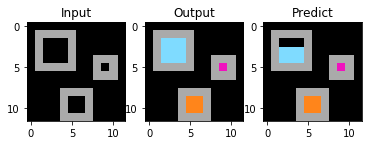

359it [02:12,  3.15it/s]

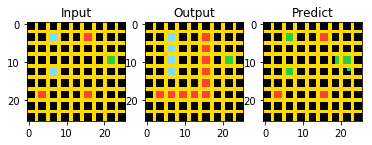

360it [02:13,  2.51it/s]

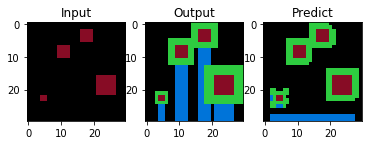

361it [02:13,  2.24it/s]

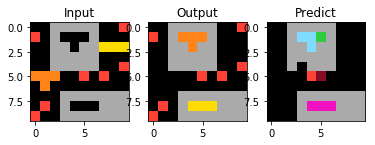

362it [02:14,  1.90it/s]

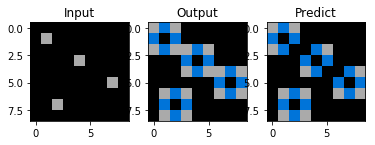

363it [02:15,  1.85it/s]

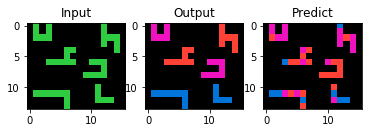

364it [02:15,  1.83it/s]

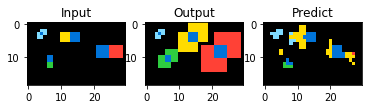

366it [02:16,  2.13it/s]

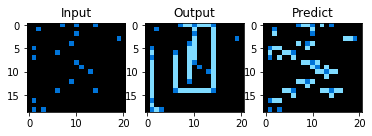

367it [02:16,  1.97it/s]

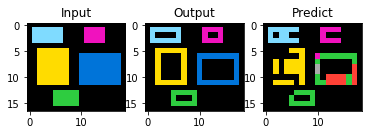

368it [02:17,  1.87it/s]

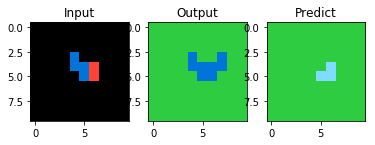

369it [02:18,  1.82it/s]

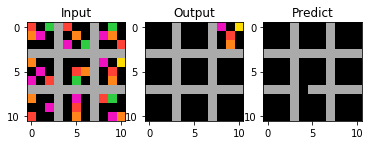

371it [02:18,  2.12it/s]

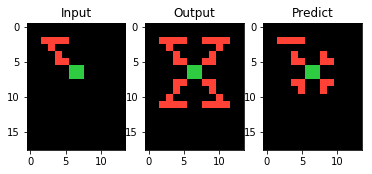

372it [02:19,  1.94it/s]

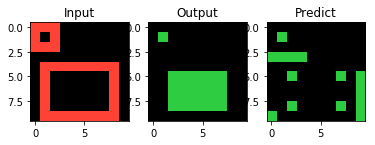

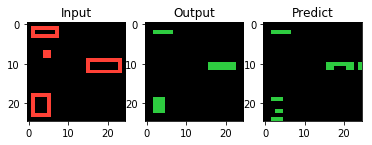

374it [02:20,  1.88it/s]

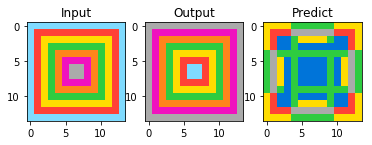

375it [02:21,  1.70it/s]

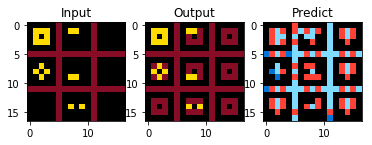

376it [02:21,  1.72it/s]

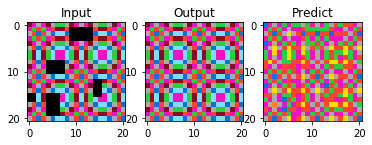

377it [02:22,  1.73it/s]

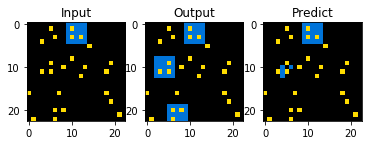

380it [02:22,  2.17it/s]

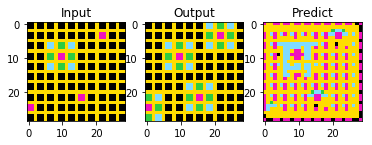

382it [02:23,  2.44it/s]

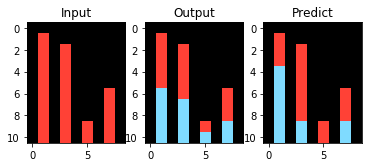

384it [02:24,  2.64it/s]

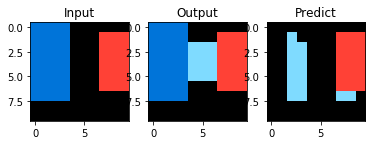

385it [02:24,  2.28it/s]

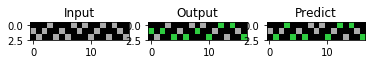

386it [02:25,  2.10it/s]

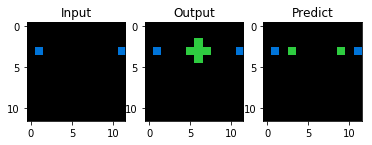

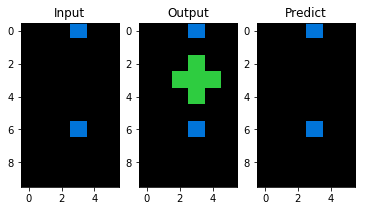

388it [02:26,  2.04it/s]

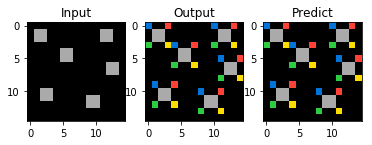

392it [02:26,  2.65it/s]

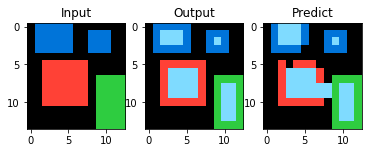

395it [02:27,  3.07it/s]

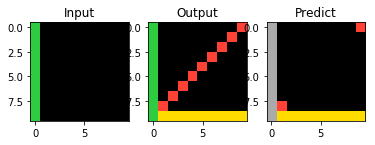

397it [02:27,  3.40it/s]

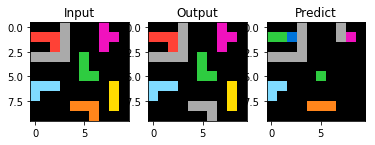

400it [02:28,  2.70it/s]


In [15]:
for task, prediction in tqdm(zip(train_tasks, train_predictions)):
    if input_output_shape_is_same(task):
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])